In [64]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder




validation_ids = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/validation_ids.csv')['participant_id'].tolist()
d1 = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAIN_CATEGORICAL_METADATA.csv')
d1 = d1.loc[~d1['participant_id'].isin(validation_ids)].reset_index(drop=True)
d2 = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAIN_QUANTITATIVE_METADATA.csv')
d2 = d2.loc[~d2['participant_id'].isin(validation_ids)].reset_index(drop=True)
labels = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAINING_SOLUTIONS.csv')
labels = labels.loc[~labels['participant_id'].isin(validation_ids)].reset_index(drop=True)
brain_probas = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/intermediate_output/adhd_probas')
df = d1.merge(d2, on='participant_id').merge(brain_probas, on='participant_id')#.merge(labels, on='participant_id')

df.head(10)



,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,...,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,ADHD_Outcome,Sex_F,adhd_proba
0,UmrK0vMLopoR,2016,1,0.0,0,1,21,45,21,45,...,5,0,5,1,0,10,NaN,1,1,0.682236
1,CPaeQkhcjg7d,2019,3,1.0,2,3,15,15,0,0,...,8,7,8,10,4,5,NaN,1,0,0.668742
2,Nb4EetVPm3gs,2016,1,1.0,8,1,18,40,0,0,...,8,5,7,6,4,9,8.239904,1,0,0.679739
3,p4vPhVu91o4b,2018,3,0.0,8,3,15,30,18,0,...,16,9,10,8,4,6,NaN,1,1,0.680319
4,M09PXs7arQ5E,2019,3,0.0,1,3,15,20,0,0,...,11,4,10,7,3,9,8.940679,1,1,0.681555
5,DgRP31gu21O9,2018,3,0.0,0,3,18,25,15,35,...,5,1,5,4,3,10,16.768195,1,0,0.676176
6,ClMA0FwvFgLY,2019,1,0.0,0,2,21,40,18,40,...,11,6,8,5,2,6,11.221309,1,0,0.672226
7,u0JiZgdGuYvh,2019,3,0.0,3,3,15,25,15,10,...,15,6,10,10,6,5,15.410221,1,0,0.673662
8,S6wKqEKnFGC4,2018,3,0.0,9,3,18,30,18,30,...,6,6,5,8,5,5,11.812457,1,0,0.677570
9,6fpygdQTScAW,2018,3,1.0,1,3,21,45,0,0,...,4,0,2,0,0,10,NaN,1,0,0.682773


In [65]:
# limiting to only a few of the most salient features from EDA
keep_cols = ['participant_id', 
 'Basic_Demos_Enroll_Year',
 'Basic_Demos_Study_Site',
 'MRI_Track_Scan_Location',
'APQ_P_APQ_P_CP',
'APQ_P_APQ_P_ID', 
'APQ_P_APQ_P_INV',
'APQ_P_APQ_P_OPD',
'APQ_P_APQ_P_PM', 
'APQ_P_APQ_P_PP',
'SDQ_SDQ_Conduct_Problems', 
'SDQ_SDQ_Difficulties_Total',
'SDQ_SDQ_Emotional_Problems',
 'SDQ_SDQ_Externalizing',
'SDQ_SDQ_Generating_Impact', 
'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Internalizing',
         'SDQ_SDQ_Peer_Problems', 
         'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan',
         'ADHD_Outcome',
           'Sex_F', 
         'adhd_proba']

df.loc[:,keep_cols].groupby('ADHD_Outcome')['adhd_proba'].describe()

,count,mean,std,min,25%,50%,75%,max
ADHD_Outcome,,,,,,,,
0,324.0,0.660943,0.003653,0.652046,0.658345,0.660350,0.663502,0.673215
1,708.0,0.679040,0.008958,0.653806,0.673128,0.678668,0.684025,0.725293


In [77]:
X_solutions = df.loc[:,keep_cols]

In [78]:
X_solutions[X_solutions['MRI_Track_Age_at_Scan'].isna()]['Basic_Demos_Study_Site'].value_counts()

Basic_Demos_Study_Site
1    160
3    118
4     27
2      3
Name: count, dtype: int64

In [79]:
X_solutions['Basic_Demos_Enroll_Year'] = X_solutions['Basic_Demos_Enroll_Year'].astype('str')
X_solutions['Basic_Demos_Study_Site'] = X_solutions['Basic_Demos_Study_Site'].astype('str')
X_solutions['MRI_Track_Scan_Location'] = X_solutions['MRI_Track_Scan_Location'].astype('str')
X_solutions['TF_MRI_Track_Age_at_Scan'] = pd.cut(X_solutions['MRI_Track_Age_at_Scan'], 4, labels=False).fillna('Missing')

In [80]:
X_solutions.groupby('TF_MRI_Track_Age_at_Scan')['ADHD_Outcome'].describe()

,count,mean,std,min,25%,50%,75%,max
TF_MRI_Track_Age_at_Scan,,,,,,,,
0.0,3.0,0.666667,0.577350,0.0,0.5,1.0,1.0,1.0
1.0,352.0,0.664773,0.472742,0.0,0.0,1.0,1.0,1.0
2.0,305.0,0.695082,0.461129,0.0,0.0,1.0,1.0,1.0
3.0,64.0,0.734375,0.445157,0.0,0.0,1.0,1.0,1.0
Missing,308.0,0.691558,0.462602,0.0,0.0,1.0,1.0,1.0


In [81]:
X_solutions.loc[X_solutions['TF_MRI_Track_Age_at_Scan']==0]

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,MRI_Track_Scan_Location,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,...,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,ADHD_Outcome,Sex_F,adhd_proba,TF_MRI_Track_Age_at_Scan
55,zSOTbT8r7FQ2,2016,1,0,3,17,47,19,14,30,...,6,10,5,3,7,0.000000,1,0,0.694478,0.0
300,NHpNjWCsdA90,2016,1,2,0,0,0,0,0,0,...,3,3,0,0,10,5.360255,1,1,0.689878,0.0
1014,x0yuhCZiG4mU,2016,1,0,3,12,46,13,15,27,...,0,1,0,0,9,0.000000,0,1,0.654065,0.0


In [82]:
X_solutions.loc[X_solutions['TF_MRI_Track_Age_at_Scan']==0,'TF_MRI_Track_Age_at_Scan'] = 'Missing' # lumping in with Missing

In [83]:
X_solutions.groupby('TF_MRI_Track_Age_at_Scan')['Sex_F'].describe()

,count,mean,std,min,25%,50%,75%,max
TF_MRI_Track_Age_at_Scan,,,,,,,,
1.0,352.0,0.355114,0.479229,0.0,0.0,0.0,1.0,1.0
2.0,305.0,0.321311,0.467748,0.0,0.0,0.0,1.0,1.0
3.0,64.0,0.359375,0.483610,0.0,0.0,0.0,1.0,1.0
Missing,311.0,0.360129,0.480811,0.0,0.0,0.0,1.0,1.0


In [84]:
X_solutions.drop('MRI_Track_Age_at_Scan', axis=1, inplace=True)
X_solutions = pd.get_dummies(X_solutions, columns=['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site','MRI_Track_Scan_Location','TF_MRI_Track_Age_at_Scan'], drop_first=True).reset_index()

In [85]:
X_solutions.set_index('participant_id', inplace=True)

X = X_solutions.drop(['ADHD_Outcome', 'Sex_F'], axis=1)
y_adhd_outcome = X_solutions['ADHD_Outcome']
y_sex_f = X_solutions['Sex_F']


In [88]:
# Split once for multiple y variables
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    X, y_adhd_outcome, y_sex_f, test_size=0.15, random_state=42
)

In [112]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Create an ensemble model using VotingClassifier (stacking)
ensemble_model= VotingClassifier(
    estimators=[('rf', rf_classifier), ('gb', gb_classifier)],
    voting='soft'  # 'hard' for majority class voting
)



# Train the ensemble model
ensemble_model.fit(X_train, y1_train) 

# Make predictions for the first target
y_pred= ensemble_model.predict_proba(X_test)
#print(f"Accuracy for target1 (classification): {accuracy_score(y1_test, y_pred):.4f}")


# Train the ensemble model for the second target
ensemble_model.fit(X_train, y2_train)  # Train for the second target (y_train2)
y_pred_s = ensemble_model.predict_proba(X_test)
#print(f"Accuracy for target2 (classification): {accuracy_score(y2_test, y_pred_s):.4f}")



<Axes: >

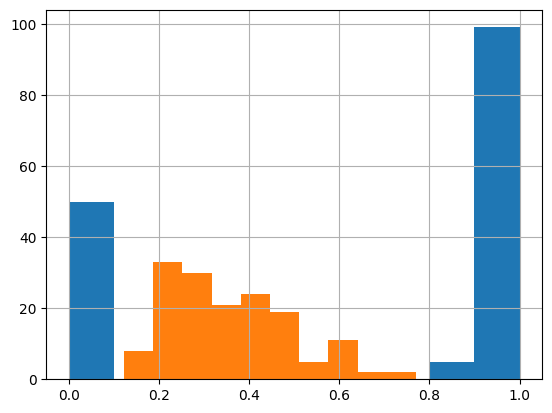

In [113]:
pd.Series(y_pred[:,1]).hist()
pd.Series(y_pred_s[:,1]).hist()

In [99]:
## Validation set:



0.6709677419354839

In [ ]:
submission = pd.DataFrame({
    'participant_id': test_connectome.index,
    'ADHD_Outcome': final_pred1,
    'Sex_F': final_pred2,
})

submission['ADHD_Outcome'] = submission['ADHD_Outcome'].astype(int)
submission['Sex_F'] = submission['Sex_F'].astype(int)

submission.to_csv('submission.csv', index=False)